In [6]:
!pip install datasets
!pip install -q bitsandbytes accelerate loralib datasets
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [1]:
import os
import torch
import json
import random
import numpy as np
import json
import datasets as ds
import pandas as pd
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer, AutoConfig
from datasets import load_dataset, Dataset, concatenate_datasets
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR
from peft import LoraConfig, get_peft_model
from random import randint, sample

from data_utils import (
    load_glue_datasets,
    load_hans_dataset,
    load_paws_qqp_dataset,
    get_dataset,
)
from context_utils import (
    create_few_shot_context, 
    select_demonstrations, 
    create_train_batch_token,
    create_validation_batch_token,
    create_paws_qqp_batch_token,
    create_hans_train_batch_token
)
from training_utils import (
    set_seed,
    CastOutputToFloat,
    get_model,
    plot_losses,
    train,
    predict
)

In [3]:
# ds.logging.set_verbosity(40)

In [4]:
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     ds.logging.set_verbosity(40)

# def print_trainable_parameters(model):
#     trainable_params = 0
#     all_param = 0
#     for _, param in model.named_parameters():
#         all_param += param.numel()
#         if param.requires_grad:
#             trainable_params += param.numel()
#     print(
#         f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
#     )

# class CastOutputToFloat(torch.nn.Sequential):
#   def forward(self, x): return super().forward(x).to(torch.float32)

# def get_model(model_name):
#     model_name = "facebook/" + model_name
#     config = AutoConfig.from_pretrained(model_name)
#     config.hidden_dropout_prob = 0.1
#     tokenizer = AutoTokenizer.from_pretrained(model_name) # tokenizer
#     teacher_model = OPTForCausalLM.from_pretrained(model_name) # teacher model
#     student_model = OPTForCausalLM.from_pretrained(model_name, config=config) # student model

#     for param in student_model.parameters():
#         param.requires_grad = False
#         if param.ndim == 1:
#             param.data = param.data.to(torch.float32)
    
#     student_model.gradient_checkpointing_enable()
#     student_model.enable_input_require_grads()
#     student_model.lm_head = CastOutputToFloat(student_model.lm_head)

#     config = LoraConfig(
#         r=16,
#         lora_alpha=32,
#         lora_dropout=0.05,
#         bias="none",
#         task_type="CAUSAL_LM"
#     )
    
#     student_model = get_peft_model(student_model, config)
#     return tokenizer, student_model, teacher_model

# def get_dataset(data_set_used):
#     datasets, labels, num_labels = load_glue_datasets(data_set_used)
    
#     if data_set_used in ['mnli', 'rte', 'hans']:
#         teacher_prompt = 'Think logically. Are the following sentences examples of entailment, yes or no?'
#         student_prompt = 'Are the following sentences examples of entailment, yes or no?'
#     elif data_set_used in ['qqp', 'paws-qqp']:
#         teacher_prompt = 'Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?'
#         student_prompt = 'Are the following sentences duplicates or paraphrases of each other, yes or no?'

#     return datasets, labels, num_labels, teacher_prompt, student_prompt
    
# # Assuming `losses` is the list of epoch losses returned from the `train` function
# def plot_losses(losses):
#     plt.figure(figsize=(10, 5))
#     plt.plot(losses, marker='o', linestyle='-', color='b')
#     plt.title('Training Loss Per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Average Loss')
#     plt.grid(True)
#     plt.show()

# def train(teacher_model, student_model, data, epochs=10, batch_size=32, device='cpu'):
#     student_model.to(device)
#     teacher_model.to(device)
#     print(id(student_model))
#     print(id(teacher_model))
    
#     student_model.train()
#     optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5, weight_decay=0.000001 )
#     epoch_losses = []

#     if (len(data) % batch_size != 0):
#         num_batches = (len(data) // batch_size) + 1
#     else:
#         num_batches  = len(data) // batch_size

#     num_datapoints = len(data)
#     total_steps = num_batches * epochs
#     warmup_ratio = int(0.1 * total_steps) 
    
#     def lr_schedular(current_step: int):
#         if current_step < warmup_ratio:
#             return float(current_step) / float(max(1,warmup_ratio))
#         return 1.
    
#     scheduler = LambdaLR(optimizer, lr_schedular)

#     for epoch in range(epochs):
#         total_loss = 0
#         samples_left = num_datapoints
        
#         for i in range(num_batches):
#             batch_loss = 0
#             if ((samples_left - batch_size) >= 0):
#                 samples_used = batch_size
#                 samples_left -= batch_size
#             else:
#                 samples_used = samples_left
#                 samples_left = 0
#             for j in range(samples_used):
#                 index = i * batch_size + j
                
#                 teacher_inputs = data[index]['context'].to(device)
#                 student_inputs = data[index]['query'].to(device)
                                
#                 teacher_outputs = teacher_model.generate(
#                     **teacher_inputs,
#                     max_length=teacher_inputs['input_ids'].shape[-1] + 1,
#                     output_scores=True,
#                     return_dict_in_generate=True
#                 )
#                 teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
#                 student_logits = student_model(**student_inputs).logits
#                 student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
#                 kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
#                 optimizer.zero_grad()
#                 kl_divergence.backward()
#                 optimizer.step()

#                 batch_loss += kl_divergence.item()

#             # Average loss for the batch
#             batch_loss /= batch_size
#             total_loss += batch_loss
#             scheduler.step()
#             #print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


#         # Average loss for the epoch
#         epoch_loss = total_loss / num_batches
#         epoch_losses.append(epoch_loss)

#         print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
#     print(f"Total loss : {total_loss/epochs}")
#     plot_losses(epoch_losses)
#     # torch.save(student_model, './models/student.pth')

# def predict(model, source, target=None, device='cpu'):
#     predict = []
#     for token in source:
#         output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
#         decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
#         predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
#         predict.append(predicted_label)
        
#     return predict


In [2]:
def run_job(dataset_used, indomain, model_name, epochs, val_len, train_len, context_len, seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    datasets, labels, num_labels, teacher_prompt, student_prompt = get_dataset(dataset_used)
    
    set_seed(seed)
    print('starting run: {}'.format(seed))
    print('loading model')
    tokenizer, student_model, teacher_model = get_model(model_name)
    print("finished loading model")

    print("loading data")
    if (dataset_used in ['mnli','rte'] and indomain == False):
        print("running a hans-based load")
        if dataset_used == 'mnli':
            datasets2, labels2, num_labels2, teacher_prompt2, student_prompt2 = get_dataset('rte')
            mnli_dataset = datasets 
            rte_dataset = datasets2
        else:
            datasets2, labels2, num_labels2, teacher_prompt2, student_prompt2 = get_dataset('mnli')
            mnli_dataset = datasets2 
            rte_dataset = datasets

        train_data_tokens, train_data_strings, indices, context_indices = create_hans_train_batch_token(
            mnli_dataset,
            rte_dataset,
            teacher_description = teacher_prompt, 
            student_description = student_prompt, 
            tokenizer=tokenizer, 
            seed=seed, 
            device=device,
            num_shots = context_len,
            num_train_samps=train_len,
        )
    else:
        train_data_tokens, train_data_strings, indices, context_indices = create_train_batch_token(
            dataset_used, 
            datasets, 
            teacher_description = teacher_prompt, 
            student_description = student_prompt, 
            tokenizer=tokenizer, 
            seed=seed, 
            device=device,
            num_shots = context_len,
            num_train_samps=train_len,
        )

    print("finished loading data")

    print("training model")
    train(teacher_model, student_model, train_data_tokens, epochs = epochs, device=device)
    print("finished training model")

    if indomain: 
        print("predicting on validation set")
       
        student_prompt_tokens, student_prompt_strings, val_indices, val_labels = create_validation_batch_token(
            dataset_used, datasets, prompt_descr=student_prompt ,tokenizer=tokenizer, device=device, limit=val_len
        )
        prediction = predict(student_model, student_prompt_tokens, tokenizer = tokenizer, device=device)  
        print("finished predicting on validation set")
    
        accuracy = accuracy_score(prediction,val_labels)
        print("finished run {}".format(seed))
        print("final result",accuracy)
        meta_domain_name="in"
        validation_set="indomain"
    else:
        if dataset_used == 'qqp':
            print("predicting on paws_qqp")
            validation_set = 'paws_qqp'
            
            dataset, label_list, num_labels = load_paws_qqp_dataset('dev_and_test.tsv')

            student_prompt_tokens, student_prompt_strings, val_indices, val_labels = create_paws_qqp_batch_token(
                dataset, prompt_descr=student_prompt ,tokenizer=tokenizer, device=device, limit=val_len
            )
            prediction = predict(student_model, student_prompt_tokens, tokenizer = tokenizer, device=device)  
            print("finished predicting on validation set")
        
            accuracy = accuracy_score(prediction,val_labels)
            print("finished run {}".format(seed))
            print("final result",accuracy)           
        else:
            print("predicting on hans")
            dataset, label_list, num_labels = load_hans_dataset()
            validation_set = 'hans'

            student_prompt_tokens, student_prompt_strings, val_indices, val_labels = create_hans_batch_token(
                dataset, prompt_descr=student_prompt ,tokenizer=tokenizer, device=device, limit=val_len
            )
            prediction = predict(student_model, student_prompt_tokens, tokenizer = tokenizer, device=device)  
            print("finished predicting on validation set")
        
            accuracy = accuracy_score(prediction,val_labels)
            print("finished run {}".format(seed))
            print("final result",accuracy)  
        meta_domain_name="out"

    if not os.path.exists('output'):
        os.makedirs('output')
    
    meta_data_file_name = f'{dataset_used}_{model_name}_{seed}_{meta_domain_name}_{epochs}_{val_len}_{train_len}_{context_len}.json'
    metadata_loc = os.path.join('output',meta_data_file_name)
    metadata = {
        'accuracy': accuracy,
        'query_indices': indices,
        'context_indices': context_indices.tolist(),
        'validation_indices': val_indices.tolist(),
        'model_name': model_name,
        'dataset_used': dataset_used,
        'validation_used': validation_set,
        'indomain':meta_domain_name,
        'seed': seed,
        'epochs': epochs,
        'val_len': val_len,
        'train_len': train_len,
        'context_len': context_len
    }
    
    with open(metadata_loc, 'w') as f:
        json.dump(metadata, f)

    return None
        

STARTED
starting run: 0
loading model
finished loading model
loading data
running a hans-based load
hans only works on even training numbers...testing
finished loading data
training model


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 1, Total Loss: 6.729210056364536
Epoch 2, Total Loss: 6.249603733420372
Epoch 3, Total Loss: 4.699594173580408
Epoch 4, Total Loss: 2.0497183427214622
Epoch 5, Total Loss: 0.9482401320710778
Epoch 6, Total Loss: 0.6461187517270446
Epoch 7, Total Loss: 0.4840905349701643
Epoch 8, Total Loss: 0.2866431139409542
Epoch 9, Total Loss: 0.27371234097518027
Epoch 10, Total Loss: 0.1745609522331506
Epoch 11, Total Loss: 0.1776965013705194
Epoch 12, Total Loss: 0.18061569286510348
Epoch 13, Total Loss: 0.15673160052392632
Epoch 14, Total Loss: 0.1384565836051479
Epoch 15, Total Loss: 0.11691729782614857
Epoch 16, Total Loss: 0.1190762518090196
Epoch 17, Total Loss: 0.15288319863611832
Epoch 18, Total Loss: 0.10741064022295177
Epoch 19, Total Loss: 0.1274639454204589
Epoch 20, Total Loss: 0.09619959752308205
Total loss : 0.004809979876154102


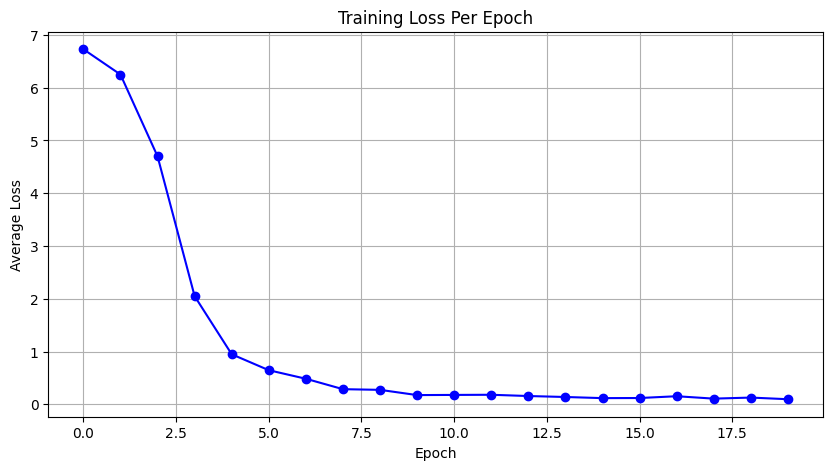

finished training model
predicting on hans


NameError: name 'create_hans_batch_token' is not defined

In [3]:
runs = 1
dataset_used = 'mnli'
indomain=False
model_name = "opt-125m"
epochs = 20
val_len = 100
train_len = 32
context_len = 16

print("STARTED")
for seed in range(runs):
    run_job(dataset_used,indomain,model_name,epochs,val_len, train_len, context_len,seed)
print("FINISHED")